In [1]:
import numpy as np
import pandas as pd

#regression
from sklearn.ensemble import RandomForestRegressor

#model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

import matplotlib.pyplot as plt

#Data preparation
County_time_series=pd.read_csv("County_time_series.csv", parse_dates=True)
CountyCrossWalk = pd.read_csv("CountyCrossWalk_Zillow.csv")

In [2]:
County_time_series.Date=pd.to_datetime(County_time_series.Date)
County_time_series['Year'] = County_time_series.Date.dt.year
County_time_series.head()

,Date,RegionName,DaysOnZillow_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,Year
0,1996-04-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,85700.0,86000.0,129700.0,NaN,NaN,NaN,NaN,NaN,1996
1,1996-04-30,10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,116800.0,116900.0,181400.0,NaN,NaN,NaN,NaN,NaN,1996
2,1996-04-30,1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,110600.0,106800.0,192300.0,NaN,NaN,NaN,NaN,NaN,1996
3,1996-04-30,1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,70000.0,70000.0,123500.0,NaN,NaN,NaN,NaN,NaN,1996
4,1996-04-30,1017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996


In [3]:
#Feature selection
County_time_series=County_time_series[['Date','Year', 'RegionName','MedianListingPrice_AllHomes','Sale_Prices','ZHVI_AllHomes', 'ZHVI_BottomTier','ZHVI_TopTier','ZHVI_MiddleTier']]
County_time_series.head()

,Date,Year,RegionName,MedianListingPrice_AllHomes,Sale_Prices,ZHVI_AllHomes,ZHVI_BottomTier,ZHVI_TopTier,ZHVI_MiddleTier
0,1996-04-30,1996,10001,NaN,NaN,85700.0,65600.0,129700.0,85700.0
1,1996-04-30,1996,10003,NaN,NaN,116800.0,81900.0,181400.0,116800.0
2,1996-04-30,1996,1003,NaN,NaN,110600.0,70600.0,192300.0,110600.0
3,1996-04-30,1996,1009,NaN,NaN,70000.0,NaN,123500.0,70000.0
4,1996-04-30,1996,1017,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
County_time_series.rename(index=str, columns={"RegionName": "FIPS", "ZHVI_AllHomes": "AverageHousePrice"}, inplace=True)
County_time_series.head()

,Date,Year,FIPS,MedianListingPrice_AllHomes,Sale_Prices,AverageHousePrice,ZHVI_BottomTier,ZHVI_TopTier,ZHVI_MiddleTier
0,1996-04-30,1996,10001,NaN,NaN,85700.0,65600.0,129700.0,85700.0
1,1996-04-30,1996,10003,NaN,NaN,116800.0,81900.0,181400.0,116800.0
2,1996-04-30,1996,1003,NaN,NaN,110600.0,70600.0,192300.0,110600.0
3,1996-04-30,1996,1009,NaN,NaN,70000.0,NaN,123500.0,70000.0
4,1996-04-30,1996,1017,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#selecting and displaying three columns from the dataset
CountyCrossWalk = CountyCrossWalk[['FIPS', 'CountyName', 'StateName']]
CountyCrossWalk["FIPS"] = CountyCrossWalk["FIPS"].astype("int64")
CountyCrossWalk.head()

,FIPS,CountyName,StateName
0,42103,Pike,Pennsylvania
1,36005,Bronx,New York
2,34013,Essex,New Jersey
3,36047,Kings,New York
4,34029,Ocean,New Jersey


In [6]:
County_time_series.isna().sum()

Date                                0
Year                                0
FIPS                                0
MedianListingPrice_AllHomes    358378
Sale_Prices                    491688
AverageHousePrice              137950
ZHVI_BottomTier                203787
ZHVI_TopTier                   126411
ZHVI_MiddleTier                137974
dtype: int64

In [7]:
#Treating null values
County_time_series['MedianListingPrice_AllHomes'].fillna(value=County_time_series['MedianListingPrice_AllHomes'].mean(), inplace=True)
County_time_series['Sale_Prices'].fillna(value=County_time_series['Sale_Prices'].median(), inplace=True)
County_time_series['AverageHousePrice'].fillna(value=County_time_series['AverageHousePrice'].median(), inplace=True)
County_time_series['ZHVI_BottomTier'].fillna(value=County_time_series['ZHVI_BottomTier'].median(), inplace=True)
County_time_series['ZHVI_TopTier'].fillna(value=County_time_series['ZHVI_TopTier'].median(), inplace=True)
County_time_series['ZHVI_MiddleTier'].fillna(value=County_time_series['ZHVI_MiddleTier'].median(), inplace=True)
County_time_series.isna().sum()

Date                           0
Year                           0
FIPS                           0
MedianListingPrice_AllHomes    0
Sale_Prices                    0
AverageHousePrice              0
ZHVI_BottomTier                0
ZHVI_TopTier                   0
ZHVI_MiddleTier                0
dtype: int64

In [8]:
CountyCrossWalk.isna().sum()

FIPS          0
CountyName    0
StateName     0
dtype: int64

In [9]:
#merged dataset
new = County_time_series.merge(CountyCrossWalk, on="FIPS")
new.head()

,Date,Year,FIPS,MedianListingPrice_AllHomes,Sale_Prices,AverageHousePrice,ZHVI_BottomTier,ZHVI_TopTier,ZHVI_MiddleTier,CountyName,StateName
0,1996-04-30,1996,10001,187952.787545,191500.0,85700.0,65600.0,129700.0,85700.0,Kent,Delaware
1,1996-05-31,1996,10001,187952.787545,191500.0,86800.0,65800.0,130000.0,86800.0,Kent,Delaware
2,1996-06-30,1996,10001,187952.787545,191500.0,88100.0,65600.0,129900.0,88100.0,Kent,Delaware
3,1996-07-31,1996,10001,187952.787545,191500.0,89100.0,65400.0,129600.0,89100.0,Kent,Delaware
4,1996-08-31,1996,10001,187952.787545,191500.0,89700.0,65200.0,129900.0,89700.0,Kent,Delaware


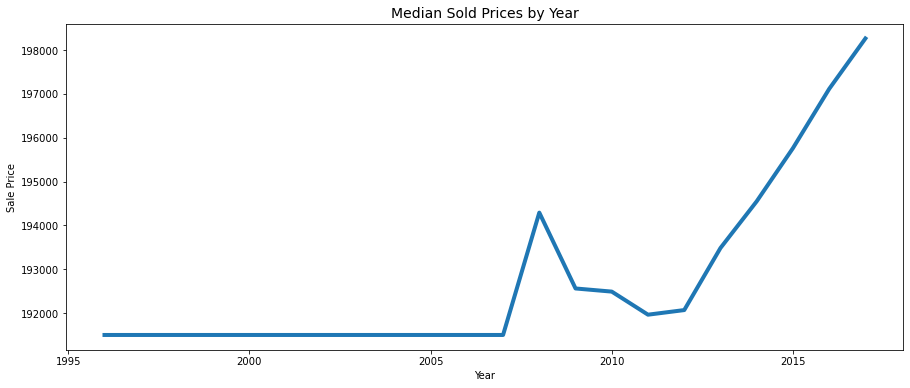

In [10]:
new.groupby(new['Year'])['Sale_Prices'].mean().dropna().plot(linewidth=4, figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Sale Price')
plt.title('Median Sold Prices by Year',fontsize = 14)
plt.show()

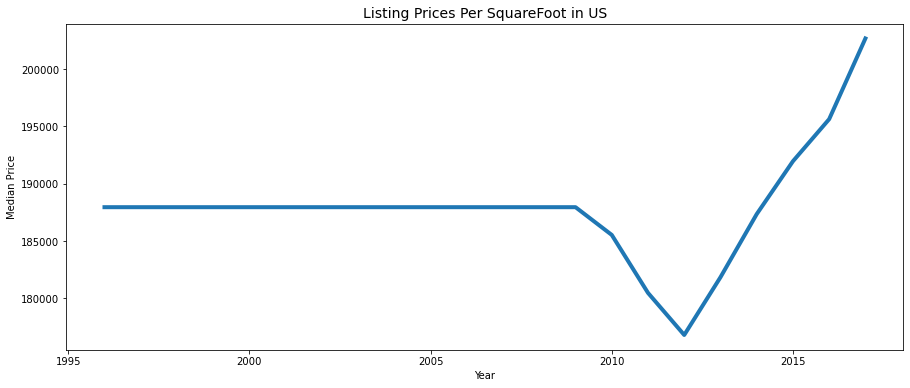

In [11]:
new.groupby(new['Year'])['MedianListingPrice_AllHomes'].mean().dropna().plot(linewidth=4, figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Median Price')
plt.title('Listing Prices Per SquareFoot in US',fontsize = 14)
plt.show()

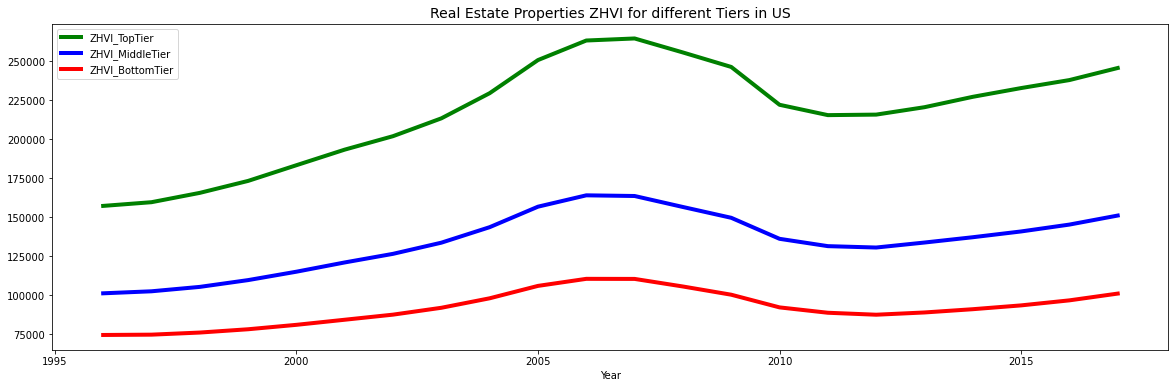

In [12]:
plt.figure(figsize=(20,6));

new.groupby(new['Year'])['ZHVI_TopTier'].mean().plot(linewidth=4,c='g')
new.groupby(new['Year'])['ZHVI_MiddleTier'].mean().plot(linewidth=4,c='b')
new.groupby(new['Year'])['ZHVI_BottomTier'].mean().plot(linewidth=4,c='r')

plt.title("Real Estate Properties ZHVI for different Tiers in US",fontsize = 14)
plt.legend()


In [13]:
#Training model
x = new[['Year', 'FIPS']]
y = new[['AverageHousePrice']] 

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

models=[RandomForestRegressor()]
model_names=['RandomForestRegressor']
rmsle=""

clf=RandomForestRegressor()
clf.fit(train_X,train_y)
test_pred=clf.predict(test_X)
rmsle=str(np.sqrt(mean_squared_log_error(test_pred,test_y)))

print("Modelling Algorithm: " + "RandomForestRegressor\n" + "RMSLE: " + rmsle)

<ipython-input-13-a3c184cd3032>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_X,train_y)


Modelling Algorithm: RandomForestRegressor
RMSLE: 0.03014078146583406


In [14]:
# Generating a few examples
print ("These are the first five entries")
print (test_X[:5])
print ("These are the model prediction for these entries")
print (clf.predict(test_X[:5]))
print ("These are the actual prices")
print (test_y[:5])

These are the first five entries
        Year   FIPS
402719  2013  45029
170060  2008  36027
254872  2007  47017
25036   2016  13123
511631  2015  28005
These are the model prediction for these entries
[101728.06992338 295262.44648546  57831.43488456 171210.27931937
 119600.        ]
These are the actual prices
        AverageHousePrice
402719            99800.0
170060           289700.0
254872            58100.0
25036            170600.0
511631           119600.0


In [21]:
#parameter tuning
params_dict={'n_estimators':[500],'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(train_X,train_y)
predi=clf_rf.predict(test_X)
print((np.sqrt(mean_squared_log_error(predi,test_y))))

0.020987384905117163


In [22]:
# Generating a few examples
print ("These are the first five entries")
print (test_X[:5])
print ("These are the model prediction for these entries")
print (clf_rf.predict(test_X[:5]))
print ("These are the actual prices")
print (test_y[:5])

These are the first five entries
        Year  FIPS
372299  2009  1001
372268  2007  1001
372238  2004  1001
372304  2010  1001
372295  2009  1001
These are the model prediction for these entries
[125556.46778757 129016.39846458 105079.00779025 139158.21103341
 125556.46778757]
These are the actual prices
372299    125300.0
372268    127500.0
372238    105900.0
372304    137600.0
372295    124000.0
Name: AverageHousePrice, dtype: float64


Modelling Algorithm: RandomForestRegressor
RMSLE: 0.021142197943192744


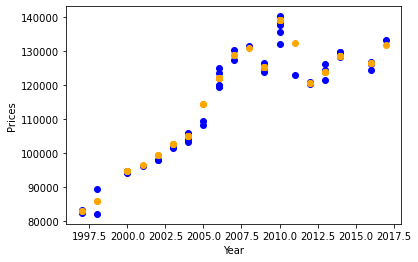

In [16]:
#Training model
x = new[['Year', 'FIPS']]
y = new[['FIPS', 'AverageHousePrice']]

a = x.loc[x["FIPS"]==1001]
b = y.loc[y["FIPS"]==1001]

train_X, test_X, train_y, test_y = train_test_split(a, b['AverageHousePrice'], test_size=0.2, random_state=0)

models=[RandomForestRegressor()]
model_names=['RandomForestRegressor']
rmsle=""

clf=RandomForestRegressor()
clf.fit(train_X,train_y)
test_pred=clf.predict(test_X)
rmsle=str(np.sqrt(mean_squared_log_error(test_pred,test_y)))

print("Modelling Algorithm: " + "RandomForestRegressor\n" + "RMSLE: " + rmsle)

plt.scatter(test_X["Year"], test_y, color='blue')
plt.scatter(test_X["Year"], test_pred, color='orange')
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

Modelling Algorithm: RandomForestRegressor
RMSLE: 0.02099658979618441


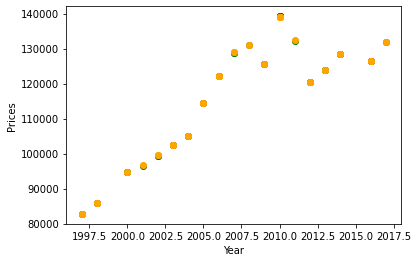

In [17]:
#parameter tuning
params_dict={'n_estimators':[200],'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(train_X,train_y)
predi=clf_rf.predict(test_X)
print("Modelling Algorithm: " + "RandomForestRegressor\n" + "RMSLE: " + str(np.sqrt(mean_squared_log_error(predi,test_y))))

plt.scatter(test_X["Year"], predi, color='green')
plt.scatter(test_X["Year"], test_pred, color='orange')
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

Modelling Algorithm: RandomForestRegressor
RMSLE: 0.021064192471826015


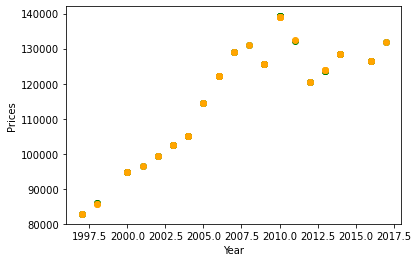

In [18]:
#parameter tuning
params_dict={'n_estimators':[500],'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(train_X,train_y)
predi=clf_rf.predict(test_X)
print("Modelling Algorithm: " + "RandomForestRegressor\n" + "RMSLE: " + str(np.sqrt(mean_squared_log_error(predi,test_y))))

plt.scatter(test_X["Year"], predi, color='green')
plt.scatter(test_X["Year"], test_pred, color='orange')
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

Modelling Algorithm: RandomForestRegressor
RMSLE: 0.021042769445837415


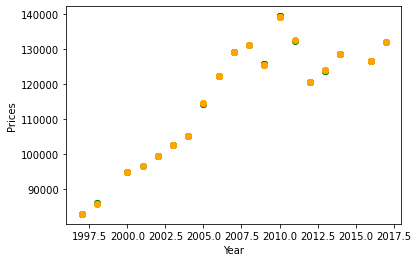

In [20]:
#parameter tuning
params_dict={'n_estimators':[800],'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(train_X,train_y)
predi=clf_rf.predict(test_X)
print("Modelling Algorithm: " + "RandomForestRegressor\n" + "RMSLE: " + str(np.sqrt(mean_squared_log_error(predi,test_y))))

plt.scatter(test_X["Year"], predi, color='green')
plt.scatter(test_X["Year"], test_pred, color='orange')
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

Modelling Algorithm: RandomForestRegressor
RMSLE: 0.020985326105683252


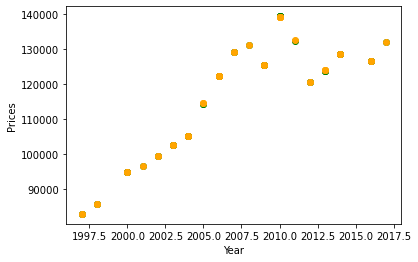

In [19]:
#parameter tuning
params_dict={'n_estimators':[1000],'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(train_X,train_y)
predi=clf_rf.predict(test_X)
print("Modelling Algorithm: " + "RandomForestRegressor\n" + "RMSLE: " + str(np.sqrt(mean_squared_log_error(predi,test_y))))

plt.scatter(test_X["Year"], predi, color='green')
plt.scatter(test_X["Year"], test_pred, color='orange')
plt.xlabel("Year")
plt.ylabel("Prices")
plt.show()

In [132]:
#import the dataset
dataset = new

###defining entropy
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts=True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy
  
##Info Gain

def InfoGain(data,split_attribute_name,target_name="class_type"):
    total_entropy = entropy(data[target_name])
    vals,counts = np.unique(data[split_attribute_name],return_counts=True)
    #cal the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).
                                dropna()[target_name])for i in range(len(vals))])
    
    #formula for information gain
    Information_Gain = total_entropy-Weighted_Entropy
    return Information_Gain

def ID3(data,originaldata,features,target_attribute_name="class_type",
        parent_node_class=None):
    #If all target_values have the same value,return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    #if the dataset is empty
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],
                                                                           return_counts=True)[1])]
    
    #If the feature space is empty
    elif len(features) == 0:
        return parent_node_class 

    #If none of the above condition holds true grow the tree

    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],
                                                                           return_counts=True)[1])]

    #Select the feature which best splits the dataset
    item_values = [InfoGain(data,feature,target_attribute_name)for feature in features] #Return the infgain values
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]

    #Create the tree structure
    tree = {best_feature:{}}

    #Remve the feature with the best info gain
    features = [i for i in features if i!= best_feature]

    #Grow the tree branch under the root node

    for value in np.unique(data[best_feature]):
        value = value
        sub_data = data.where(data[best_feature]==value).dropna()
        #call the ID3 algotirthm
        subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
        #Add the subtree
        tree[best_feature][value] = subtree
    return(tree)

#Predict
def predict(query,tree,default=1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
               result = tree[key][query[key]]
            except:
               return default

            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result
##check the accuracy

def train_test_split(dataset):
    training_data = dataset.iloc[:80].reset_index(drop=True)
    testing_data = dataset.iloc[80:].reset_index(drop=True)
    return training_data,testing_data
training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]

def test(data,tree):
   queries = data.iloc[:,:-1].to_dict(orient="records")
   predicted = pd.DataFrame(columns=["predicted"])

   #calculation of accuracy

   for i in range(len(data)):
       predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0)
   print("The Prediction accuracy is:",(np.sum(predicted["predicted"]==data["class_type"])/len(data))*100,'%')
  
#Train the tree,print the tree abnd predict the accuracy
tree = ID3(training_data,training_data,training_data.columns[:-1])
pprint(tree)
test(testing_data,tree)

KeyError: 'class_type'